In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mysql_connection as mc
%matplotlib inline

In [3]:
conn = mc.connect()

Please insert your password:········


# Sellers  (only after Jan. 1st, 2017)

Definition: *A user that has sold a product in a given time frame*

## 1. How many sellers do we have?

In [2]:
sellers_query = """
SELECT DISTINCT
    oi.seller_id
FROM olist.order_items oi
    INNER JOIN olist.orders o
    ON oi.order_id = o.order_id
WHERE o.order_purchase_timestamp >= '2017-01-01'
"""

In [5]:
sellers = pd.read_sql(sellers_query, conn)

In [6]:
sellers.shape

(3068, 1)

We have had a total of 3068 unique sellers after Jan. 1st 2017

## 2. How much do they sell?

In [4]:
seller_qty_query = """
SELECT
    oi.seller_id
    ,COUNT(*)     AS items_sold
FROM olist.order_items oi
    INNER JOIN olist.orders o
    ON oi.order_id = o.order_id
WHERE TRUE
    AND o.order_purchase_timestamp >= '2017-01-01'
GROUP BY oi.seller_id
"""

seller_qty = pd.read_sql(seller_qty_query, conn)

In [5]:
seller_qty.shape

(3068, 2)

In [6]:
seller_qty.describe()

,items_sold
count,3068.000000
mean,36.597132
std,119.512140
min,1.000000
25%,2.000000
50%,8.000000
75%,25.000000
max,2033.000000


- The top selling seller has sold 2033 items
- On average, sellers sell 36.6 items
- Half of the sellers have sold less or equal to 8 items
- A quarter of our sellers have sold more or equal to 25 items
- The lowest performing seller has sold 1 item

In [7]:
type(seller_qty.describe())

pandas.core.frame.DataFrame

In [11]:
seller_qty.describe().loc["mean"]

items_sold    36.597132
Name: mean, dtype: float64

In [15]:
seller_qty["items_sold"].mean()

36.59713168187744

In [16]:
np.percentile(seller_qty["items_sold"], 50)

8.0

In [17]:
np.quantile(seller_qty["items_sold"], .5)

8.0

Draw a boxplot (Box and whisker plot)

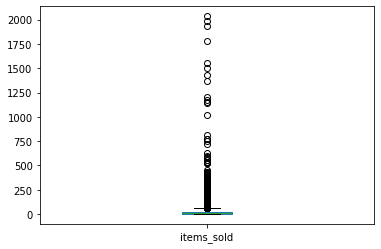

In [24]:
seller_qty["items_sold"].plot(kind="box");

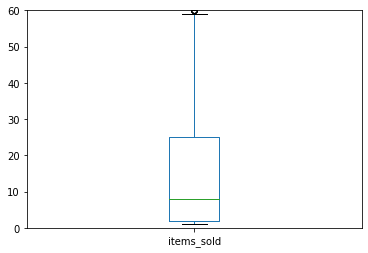

In [23]:
seller_qty["items_sold"].plot(kind="box", ylim=(0,60));

In [27]:
seller_qty.loc[seller_qty["items_sold"] > 58].shape

(409, 2)

There are 409 sellers outside of our whiskers!

-> Data is right skewed

Show histogram

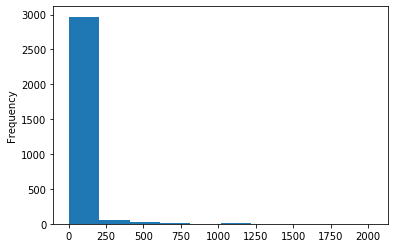

In [29]:
seller_qty["items_sold"].plot(kind="hist");

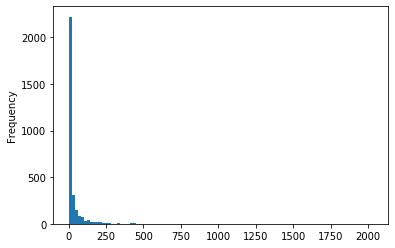

In [31]:
seller_qty["items_sold"].plot(kind="hist", bins=100);

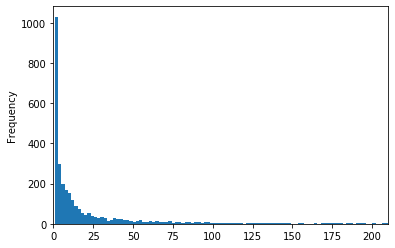

In [33]:
seller_qty["items_sold"].plot(kind="hist", bins=1000, xlim=(0,210));

-> Yes, it's really skewed

In [38]:
np.percentile(seller_qty["items_sold"], range(1,100))

array([  1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
         1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
         2.  ,   2.  ,   2.  ,   2.  ,   2.  ,   2.  ,   2.  ,   2.  ,
         2.  ,   2.  ,   3.  ,   3.  ,   3.  ,   3.  ,   3.  ,   3.  ,
         3.  ,   4.  ,   4.  ,   4.  ,   4.  ,   4.  ,   5.  ,   5.  ,
         5.  ,   5.  ,   5.  ,   6.  ,   6.  ,   6.  ,   7.  ,   7.  ,
         7.  ,   8.  ,   8.  ,   8.  ,   9.  ,   9.  ,   9.  ,  10.  ,
        10.  ,  11.  ,  11.  ,  11.  ,  12.  ,  12.  ,  13.  ,  14.  ,
        14.  ,  15.  ,  16.  ,  16.56,  17.  ,  18.  ,  19.57,  21.  ,
        22.  ,  23.  ,  25.  ,  26.  ,  28.  ,  30.  ,  32.  ,  35.  ,
        38.  ,  40.  ,  43.  ,  46.  ,  50.  ,  55.  ,  61.  ,  66.  ,
        73.  ,  81.  ,  89.  ,  98.  , 111.  , 130.  , 147.65, 177.32,
       211.99, 304.64, 432.32])

In [45]:
seller_qty["items_sold"].quantile([i/10 for i in range(1,10)])

0.1     1.0
0.2     2.0
0.3     3.0
0.4     5.0
0.5     8.0
0.6    11.0
0.7    18.0
0.8    35.0
0.9    81.0
Name: items_sold, dtype: float64

- 90% of the sellers have sold no more than 81 items

## 3. How much revenue are they generating?

In [46]:
sellers_rev_query = """
SELECT
    oi.seller_id
    ,SUM(oi.price)  AS revenue
FROM olist.order_items oi
    INNER JOIN olist.orders o
    ON oi.order_id = o.order_id
WHERE TRUE
    AND o.order_purchase_timestamp >= '2017-01-01'
GROUP BY oi.seller_id
"""

sellers_rev = pd.read_sql(sellers_rev_query, conn)

In [48]:
sellers_rev.describe()

,revenue
count,3068.000000
mean,4413.904101
std,13945.167724
min,3.500000
25%,210.150003
50%,829.920002
75%,3322.785002
max,229472.628349


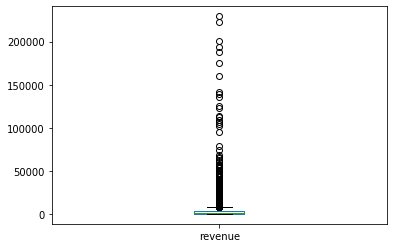

In [49]:
sellers_rev["revenue"].plot(kind="box");

- The highest grossing seller generated 229,473 Rios
- Half of the sellers generated less than 830 Rios
- Only a quarter of the sellers generated more than 3320 Rios

## How much do we depend on the top sellers?

In [56]:
# 1. sort by rev desc
top_sellers = (sellers_rev
               .sort_values("revenue", ascending=False)
               .reset_index(drop=True))
top_sellers.head()

,seller_id,revenue
0,4869f7a5dfa277a7dca6462dcf3b52b2,229472.628349
1,53243585a1d6dc2643021fd1853d8905,222776.049545
2,4a3ca9315b744ce9f8e9374361493884,200472.921459
3,fa1c13f2614d7b5c4749cbc52fecda94,194042.029396
4,7c67e1448b00f6e969d365cea6b010ab,187923.891939


In [60]:
# 2. rank sellers
top_sellers = (top_sellers
               .assign(rank=top_sellers.index + 1)
# 3. cumulative revenue
               .assign(cum_rev=top_sellers["revenue"].cumsum()))

In [82]:
# 4. percentiles
top_sellers = (top_sellers
               .assign(top_n_perc=((top_sellers["rank"] / len(top_sellers)) * 100))
               .assign(percentile=((1 - top_sellers["rank"] / len(top_sellers)) * 100).astype(int))
# 5. revenue contribution
               .assign(revenue_contribution=((top_sellers["cum_rev"] / top_sellers["revenue"].sum()) * 100).astype(int)))

In [88]:
top_sellers.head(40)

,seller_id,revenue,rank,cum_rev,percentile,revenue_contribution,top_n_perc
0,4869f7a5dfa277a7dca6462dcf3b52b2,229472.628349,1,2.294726e+05,99,1,0.032595
1,53243585a1d6dc2643021fd1853d8905,222776.049545,2,4.522487e+05,99,3,0.065189
2,4a3ca9315b744ce9f8e9374361493884,200472.921459,3,6.527216e+05,99,4,0.097784
3,fa1c13f2614d7b5c4749cbc52fecda94,194042.029396,4,8.467636e+05,99,6,0.130378
4,7c67e1448b00f6e969d365cea6b010ab,187923.891939,5,1.034688e+06,99,7,0.162973
5,7e93a43ef30c4f03f38b393420bc753a,175032.869331,6,1.209720e+06,99,8,0.195567
6,da8622b14eb17ae2831f4ac5b9dab84a,160236.568089,7,1.369957e+06,99,10,0.228162
7,7a67c85e85bb2ce8582c35f2203ad736,141745.531660,8,1.511702e+06,99,11,0.260756
8,1025f0e2d44d7041d6cf58b6550e0bfa,138968.550537,9,1.650671e+06,99,12,0.293351
9,955fee9216a65b617aa5c0531780ce60,135171.700697,10,1.785843e+06,99,13,0.325945


- Out top 7 sellers account for 10% of our revenue
- Our top 1% sellers account for approx. a quarter of our revenue

In [89]:
top_sellers.loc[top_sellers["revenue_contribution"].between(49,51)]

,seller_id,revenue,rank,cum_rev,percentile,revenue_contribution,top_n_perc
122,59fb871bf6f4522a87ba567b42dafecf,21598.580399,123,6.643533e+06,95,49,4.009126
123,d2374cbcbb3ca4ab1086534108cc3ab7,21223.920174,124,6.664757e+06,95,49,4.041721
124,48162d548f5b1b11b9d29d1e01f75a61,20510.139845,125,6.685267e+06,95,49,4.074316
125,729f06993dac8e860d4f02d7088ca48a,20485.079700,126,6.705752e+06,95,49,4.106910
126,00ee68308b45bc5e2660cd833c3f81cc,20260.000000,127,6.726012e+06,95,49,4.139505
127,bfd27a966d91cfaafdb25d076585f0da,19921.000000,128,6.745933e+06,95,49,4.172099
128,004c9cd9d87a3c30c522c48c4fc07416,19712.710007,129,6.765646e+06,95,49,4.204694
129,d650b663c3b5f6fb392b6326366efa9a,19242.899994,130,6.784888e+06,95,50,4.237288
130,821fb029fc6e495ca4f08a35d51e53a5,19187.419968,131,6.804076e+06,95,50,4.269883
131,f457c46070d02cadd8a68551231220dd,19093.000183,132,6.823169e+06,95,50,4.302477


- Half of our revenue is generated by 130 sellers (the top 4.2%)